<a href="https://colab.research.google.com/github/YoheiMurata/moomoo-lab.keras/blob/master/DCGAN_Character.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DCGANで好きなキャラクター画像を生成させてみよう
DCGANを利用して、好きなキャラクターの画像を生成させてみましょう


In [1]:
import keras
from keras import Sequential, Model
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.core import Activation
from keras.layers import Flatten, Dense, Input, Reshape
from keras.optimizers import Adam
from keras.initializers import RandomNormal as RN
import numpy as np

from tqdm import tqdm

Using TensorFlow backend.


In [0]:
# データセット作成に必要なライブラリのインポート
from google.colab import drive
import os
import sys
import glob
from PIL import Image
import datetime
import matplotlib.pyplot as plt

In [6]:
drive.mount('drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at drive


In [0]:
# 潜在変数の定義
noise_dim = 100
image_size = 128
ALPHA = 0.1

In [0]:
'''
指定したディレクトリ配下の画像ファイル一覧をデータセット化して
指定した場所に出力する
-----
引数:
  image_path: 画像ファイル一覧のファイルパス
  output_path: データセット出力先のファイルパス
  image_size: 出力するデータセット画像のサイズ（正方形)
'''
def make_dataset( image_path, output_path, image_size = 32 ):
  # 指定したパスがなかった場合は終了する
  if not os.path.exists( image_path ):
    print('no such a path: ' + image_path )
    sys.exit( 0 )
  image_list = glob.glob( image_path + '*' )

  datas = []

  for filename in image_list:
    # 画像を読み込んでリサイズ
    img = Image.open( filename )
    img = img.convert('RGB')
    img = img.resize( ( image_size, image_size ) )

    # 回転の左右反転画像の作成
    #for angle in range( -20, 21, 5 ):
     # rotate_image = img.rotate( angle )
    rotate_flip_image = img.transpose( Image.FLIP_LEFT_RIGHT )
     # datas.append( make_data( rotate_image, image_size ) )
    datas.append( make_data( rotate_flip_image, image_size ) )
  
  # ディレクトリが存在しない場合は作成する
  if not os.path.exists( output_path ):
    os.mkdir( output_path )
  # 指定した場所にデータセットを保存
  dataset = np.array( datas, dtype = np.float32 )
  np.savez( output_path + 'datasets.npz', X = dataset )


def make_data( image, image_size ):
  data = np.asarray( image )
  data = ( data.astype( np.float32 ) - 127.5 ) / 127.5
  data = data.reshape( image_size, image_size, 3 )
  return data



In [0]:
make_dataset('drive/My Drive/kobayashi/kobayashi-02/kanna-for-gan/', 'drive/My Drive/kobayashi/gan_dataset/', image_size = image_size)

In [0]:
datas = np.load('drive/My Drive/kobayashi/gan_dataset/datasets.npz')
X = datas['X']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


151

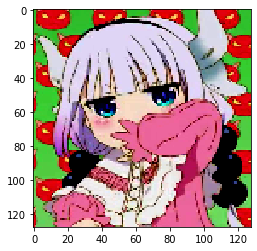

In [11]:
plt.imshow(X[20])
len(X)

In [0]:
'''
Generatorの作成
'''
def make_generator():
  model = Sequential()

  # 1st layer
  model.add( Dense( 1024, input_shape = ( noise_dim, ) ) )
  model.add( LeakyReLU( alpha = ALPHA ) )
  model.add( Dense( 4 * 4 * 512 ) )
  model.add( BatchNormalization() )
  model.add(LeakyReLU( alpha = ALPHA )) 
  model.add( Reshape( ( 4, 4, 512 ) ) )

  # 2nd layer
  model.add( Conv2DTranspose( filters = 256, kernel_size = 5, strides = 2, padding = 'same', kernel_initializer=RN(mean=0.0, stddev=0.02), use_bias = False ) )
  model.add(LeakyReLU( alpha = ALPHA ) )
  model.add( Conv2D( filters = 256, kernel_size = 2, padding = 'same', kernel_initializer=RN(mean=0.0, stddev=0.02), use_bias = False ) ) 
  model.add( LeakyReLU( alpha = ALPHA )) 

  # 3rd layer
  model.add( Conv2DTranspose( filters = 128, kernel_size = 5, strides = 2, padding = 'same', kernel_initializer=RN(mean=0.0, stddev=0.02), use_bias = False ) ) 
  model.add(LeakyReLU( alpha = ALPHA ) )

  # 4th layer
  model.add( Conv2DTranspose( filters = 64, kernel_size = 5, strides = 2, padding = 'same', kernel_initializer=RN(mean=0.0, stddev=0.02), use_bias = False ) )
  model.add( BatchNormalization() )
  model.add( Conv2D( filters = 64, kernel_size = 3, padding = 'same' ) )
  model.add( LeakyReLU( alpha = ALPHA ))

  # 5th layer
  model.add( Conv2DTranspose( filters = 32, kernel_size = 5, strides = 2, padding = 'same', kernel_initializer=RN(mean=0.0, stddev=0.02), use_bias = False ) )
  model.add( BatchNormalization() )
  model.add( Conv2D( filters = 32, kernel_size = 3, padding = 'same' ) )
  model.add( LeakyReLU( alpha = ALPHA ))

  # 6th layer
  model.add( Conv2DTranspose( filters = 3, kernel_size = 5, strides = 2, padding = 'same', kernel_initializer=RN(mean=0.0, stddev=0.02), use_bias = False ) )
  model.add( Activation('tanh') )

  return model



In [0]:
'''
Discriminatorの作成
'''
def make_discriminator():
  model = Sequential()

  # 1st layer
  model.add( Conv2D( filters = 32, kernel_size = 5, strides = 2, input_shape = ( image_size, image_size, 3 ), padding = 'same', kernel_initializer=RN(mean=0.0, stddev=0.02) ) )
  model.add( LeakyReLU( alpha = ALPHA ) )

  # 2nd layer
  model.add( Conv2D( filters = 64, kernel_size = 5, strides = 2, padding = 'same', kernel_initializer=RN(mean=0.0, stddev=0.02) ) )
  model.add( BatchNormalization() )
  model.add( LeakyReLU( alpha = ALPHA ) )

  # 3rd layer
  model.add( Conv2D( filters = 128, kernel_size = 5, strides = 2, padding = 'same', kernel_initializer=RN(mean=0.0, stddev=0.02)) )
  model.add( LeakyReLU( alpha = ALPHA ) )
  model.add( Flatten() )
  model.add( Dense( 1, activation = 'sigmoid' ) )

  return model

In [0]:
'''
Combinedの作成
Combinedは、generatorを学習する用のネットワークのこと
'''
def make_combined( generator, discriminator ):
  discriminator.trainable = False

  model = Sequential( [ generator, discriminator ] )

  return model

In [0]:
'''
生成した画像の表示と保存
'''
FAKE_IMAGE_PATH = 'drive/My Drive/kobayashi/genImage/'
def saveImage( iteration, noise ):
  fig, axes = plt.subplots( 5, 5 )
  images = generator.predict( noise )
  images = images * 127.5 + 127.5
  images = images.astype( np.int32 )

  for img, ax in zip( images, axes.flatten() ):
    ax.imshow( img )
    ax.axis('off')
  
  if not os.path.exists(FAKE_IMAGE_PATH):
    os.mkdir(FAKE_IMAGE_PATH)

  fname = FAKE_IMAGE_PATH + 'generate_%05d.png' % iteration
  fig.savefig( fname )

  plt.close()


In [0]:
'''
モデルの作成と学習を始める
'''
# 学習済モデルが存在した場合は、ロードして学習を再開する
generator = make_generator()
if os.path.exists('drive/My Drive/kobayashi/generator.hdf5'):
  generator.load_weights('drive/My Drive/kobayashi/generator.hdf5')

# 学習済モデルが存在した場合は、ロードして学習を再開する
discriminator = make_discriminator()
# discriminatorをコンパイルする
if os.path.exists('drive/My Drive/kobayashi/discriminator.hdf5'):
  discriminator.load_weights('drive/My Drive/kobayashi/discriminator.hdf5')
discriminator.compile( loss = 'binary_crossentropy', optimizer = Adam( lr = 0.0001, beta_1 = 0.3 ), metrics = [ 'accuracy' ] )

# combinedをコンパイルする
combined = make_combined( generator, discriminator )
combined.compile( loss = 'binary_crossentropy', optimizer = Adam( lr = 0.0001, beta_1 = 0.3 ), metrics = [ 'accuracy' ] )
#combined.summary()


timestamp = datetime.datetime.now().strftime("%H:%M:%S")
checkPointNoise = np.random.uniform( -1, 1, ( 25, noise_dim ) )

batch_size = 500
iteration = 20000
checkpoint = 100

try:

  for i in tqdm( range( iteration ) ):  
    idx = np.random.randint( 0, len( X ), batch_size )

    realImages = X[ idx ]
    realImages = realImages.reshape( batch_size, image_size, image_size, 3 )

    noise = np.random.uniform( -1, 1, size = ( batch_size, noise_dim ) )
    generatedImages = generator.predict( noise )

    d_loss_real = discriminator.train_on_batch( realImages, np.ones( ( batch_size, 1 ) ) )
    d_loss_fake = discriminator.train_on_batch( generatedImages, np.zeros( ( batch_size, 1 ) ) )
    d_loss = 0.5 * np.add( d_loss_real, d_loss_fake ) 

    noise = np.random.uniform( -1, 1, size = ( batch_size, noise_dim ) )
    g_loss = combined.train_on_batch( noise, np.ones( ( batch_size, 1 ) ) )

    if i % checkpoint == 0:
      saveImage( i, checkPointNoise )
      print('d_loss_real: {}, d_loss_fake: {}, g_loss: {}, batch_size: {}'.format(d_loss_real, d_loss_fake, g_loss, batch_size)) 
    
    if i % 2000 == 0:
      discriminator.save('drive/My Drive/kobayashi/discriminator{}.hdf5'.format(i))
      generator.save('drive/My Drive/kobayashi/generator{}.hdf5'.format(i))

except Exception as e:
  print(e)
finally:
  discriminator.save('drive/My Drive/kobayashi/discriminator.hdf5')
  generator.save('drive/My Drive/kobayashi/generator.hdf5')
















Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


  0%|          | 0/20000 [00:00<?, ?it/s]

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


d_loss_real: [7.8440235e-07, 1.0], d_loss_fake: [1.00000015e-07, 1.0], g_loss: [16.118095, 0.0], batch_size: 500


  0%|          | 1/20000 [00:18<102:28:00, 18.44s/it]/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
  1%|          | 101/20000 [02:55<10:03:24,  1.82s/it]

d_loss_real: [1.1920935e-07, 1.0], d_loss_fake: [1.00000015e-07, 1.0], g_loss: [16.118095, 0.0], batch_size: 500


  1%|          | 111/20000 [03:11<8:47:21,  1.59s/it]